# Fairness Checking: Linear Program (Statistical Parity) w/ Different Models
This notebook solves the SP Linear Program with the results from the 40 different models (20 models with varying depths, 20 models with varying hidden units) in compas_nn_risk_score_diffmodel.ipynb.

In [0]:
!pip install pulp

In [0]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
NUMBER_OF_MODELS = 20

# Case 1: Depth NNs
We have 100 different models with varying depths. diffmodel_0 has the shallowest depth (1 layer), and diffmodel_99 has the deepest depth (100 layers).

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

Import for each of the twenty f(X). We'll call them f_1(X), f_2(X), ... f_20(X).

In [0]:
df = []
for i in range(NUMBER_OF_MODELS):
  df.append(pd.read_csv('/content/drive/My Drive/colab/fairness_checking/depth_models/diffmodel_{}.csv'.format(i)))

In [0]:
# Sanity Check: make sure we have different f(X)'s
df[0].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.052690,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.829273,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.172630,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.126032,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.632580,1


In [0]:
# Sanity Check: make sure we have different f(X)'s
df[NUMBER_OF_MODELS-1].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.44713,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.44713,0
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.44713,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.44713,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.44713,0


In [0]:
# Our protected variable A is race, and a = 0 or a = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
a = df[0]['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0)
print(pi_1)

0.4943181818181818
0.5056818181818182


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = []
for i in range(len(df)):
  f_X.append(df[i]['prediction_probs'])
  np.asarray(f_X[i])

In [0]:
# Check if the dimensions match
print(len(f_X[0]))
print(len(f_X[1]))
print(len(f_X[2]))
print(len(f_X[18]))
print(len(f_X[19]))
print(len(a_0_indices) + (len(a_1_indices)))

1232
1232
1232
1232
1232
1232


## Linear Program Function
Create a reusable function for each linear program.

In [0]:
# Input: function f(X)
# Output: (solved) model, weights
def SP_linear_prog(f_X):
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1
  
  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[w[i]] = w[i].varValue

## Solve Linear Programs
Solve the linear program for each of the f(X).

In [0]:
# Solve for each of the f(X)
models = []
weights = []

for i in range(len(f_X)):
  model, weight_results = SP_linear_prog(f_X[i])
  models.append(model)
  weights.append(weight_results)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} : ".format(i)
  print(result_string + str(pulp.value(models[i].objective)))

Objective for f(X)_0 : 0.9745228162924563
Objective for f(X)_1 : 0.9674091562268906
Objective for f(X)_2 : 0.9798455212731789
Objective for f(X)_3 : 0.9810582062717512
Objective for f(X)_4 : 0.9848847292798241
Objective for f(X)_5 : 0.9676872962111969
Objective for f(X)_6 : 0.9679024862611537
Objective for f(X)_7 : 0.9661339962491915
Objective for f(X)_8 : 0.966697719246359
Objective for f(X)_9 : 0.9716570612379084
Objective for f(X)_10 : 0.9907285222926168
Objective for f(X)_11 : 0.9731520362296286
Objective for f(X)_12 : 0.9337520343759547
Objective for f(X)_13 : 0.9853633603199855
Objective for f(X)_14 : 0.8941869446013132
Objective for f(X)_15 : 0.7625218019493395
Objective for f(X)_16 : 0.9938053244808099
Objective for f(X)_17 : -3.2498191915308894e-09
Objective for f(X)_18 : 0.9864155342734541
Objective for f(X)_19 : -3.252273950149487e-09


Text(0.5, 1.0, 'NN Depth vs. SP LP Objective Value')

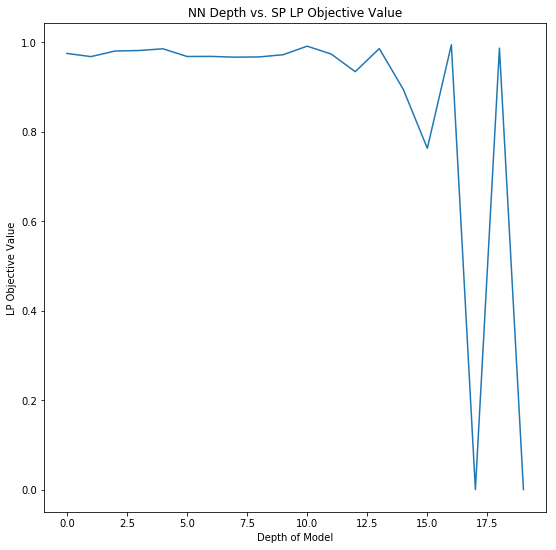

In [0]:
# Plot objective values
objectives = []
for i in range(len(models)):
  objectives.append(pulp.value(models[i].objective))

plt.figure(figsize=(9,9))
plt.plot(objectives)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Depth vs. SP LP Objective Value')

Text(0.5, 1.0, 'NN Depth vs. Model Test Accuracy')

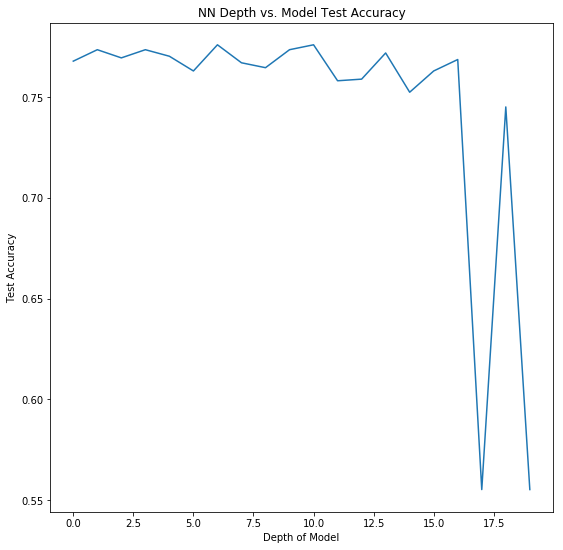

In [0]:
# Plot training accuracies over depth
depth_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/depth_models/depth_model_accuracies.csv')
depth_model_accuracies_df.head(5)
depth_model_acc = depth_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(depth_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Depth of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Depth vs. Model Test Accuracy')

In [0]:
# Save as a CSV
df = pd.DataFrame({'Depth of Model (Layers)':range(1,NUMBER_OF_MODELS + 1), 'SP LP Objective Values':objectives})
df.head(5)
df.to_csv('/content/drive/My Drive/colab/fairness_checking/sp_depth_models.csv')

# Case 2: Hidden Unit NNs
We have 20 different models with varying hidden units. diffmodel_0 has the least hidden units (20 per layer), and diffmodel_100 has the most hidden units (2020 per layer). Each model has a constant 5 layers.

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

Import for each of the 100 f(X). We'll call them f_1(X), f_2(X), ... f_100(X).

In [0]:
df = []
for i in range(NUMBER_OF_MODELS):
  df.append(pd.read_csv('/content/drive/My Drive/colab/fairness_checking/unit_models/diffmodel_{}.csv'.format(i)))

In [0]:
# Sanity Check: make sure we have different f(X)'s
df[0].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.056160,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.749724,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.169747,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.090673,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.600647,1


In [0]:
# Sanity Check: make sure we have different f(X)'s
df[19].head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.049422,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.731862,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.194312,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.071848,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.619357,1


In [0]:
# Our protected variable A is race, and a = 0 or a = 1. Doesn't matter which DF
# we get this from because they are all in the same order.
a = df[0]['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0)
print(pi_1)

0.4943181818181818
0.5056818181818182


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = []
for i in range(len(df)):
  f_X.append(df[i]['prediction_probs'])
  np.asarray(f_X[i])

In [0]:
# Check if the dimensions match
print(len(f_X[0]))
print(len(f_X[1]))
print(len(f_X[2]))
print(len(f_X[18]))
print(len(f_X[19]))
print(len(a_0_indices) + (len(a_1_indices)))

1232
1232
1232
1232
1232
1232


## Linear Program Function
Create a reusable function for each linear program.

In [0]:
# Input: function f(X)
# Output: (solved) model, weights
def SP_linear_prog(f_X):
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1
  
  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[w[i]] = w[i].varValue

## Solve Linear Programs
Solve the linear program for each of the f(X).

In [0]:
# Solve for each of the f(X)
models = []
weights = []

for i in range(len(f_X)):
  model, weight_results = SP_linear_prog(f_X[i])
  models.append(model)
  weights.append(weight_results)

In [0]:
# Get all the objective values
for i in range(len(f_X)):
  result_string = "Objective for f(X)_{} : ".format(i)
  print(result_string + str(pulp.value(models[i].objective)))

Objective for f(X)_0 : 0.9491712392800318
Objective for f(X)_1 : 0.9825877463037281
Objective for f(X)_2 : 0.9739487212935094
Objective for f(X)_3 : 0.9728615522469208
Objective for f(X)_4 : 0.9819817552847826
Objective for f(X)_5 : 0.9803513242592857
Objective for f(X)_6 : 0.9738019262477137
Objective for f(X)_7 : 0.9533783461725124
Objective for f(X)_8 : 0.9741513942834508
Objective for f(X)_9 : 0.9802107883406506
Objective for f(X)_10 : 0.9588199323230006
Objective for f(X)_11 : 0.9731145362538713
Objective for f(X)_12 : 0.973344882275924
Objective for f(X)_13 : 0.9839504003237023
Objective for f(X)_14 : 0.9828143402928552
Objective for f(X)_15 : 0.9536347961624241
Objective for f(X)_16 : 0.9836891873166831
Objective for f(X)_17 : 0.9724434393254208
Objective for f(X)_18 : 0.9706910532728984
Objective for f(X)_19 : 0.962480369203203


Text(0.5, 1.0, 'NN Hidden Units vs. SP LP Objective Value')

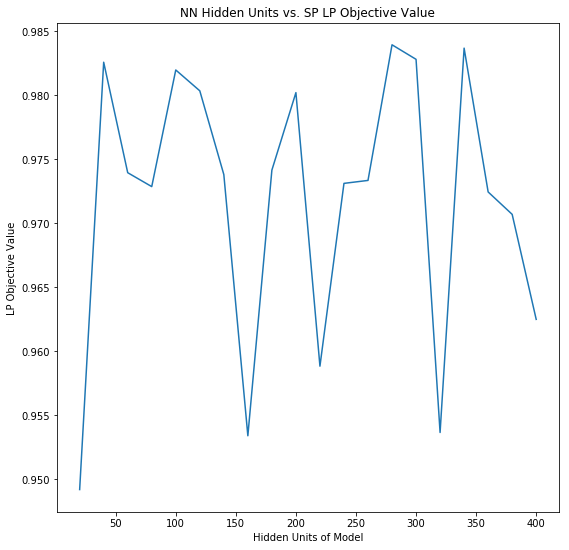

In [0]:
# Plot objective values
objectives = []
for i in range(len(models)):
  objectives.append(pulp.value(models[i].objective))
  
# Get values for x axis
x_axis = []
units = 20
for i in range(len(models)):
  x_axis.append(units)
  units += 20

plt.figure(figsize=(9,9))
plt.plot(x_axis, objectives)
plt.xlabel('Hidden Units of Model')
plt.ylabel('LP Objective Value')
plt.title('NN Hidden Units vs. SP LP Objective Value')

Text(0.5, 1.0, 'NN Hidden Units vs. Model Test Accuracy')

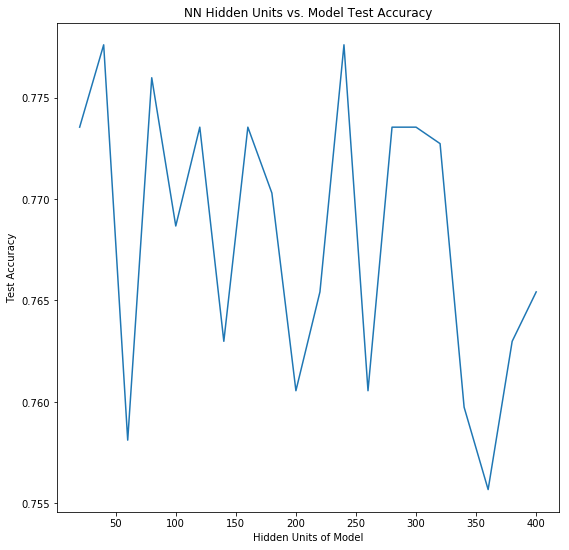

In [0]:
# Plot training accuracies over depth
unit_model_accuracies_df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/unit_models/unit_model_accuracies.csv')
unit_model_accuracies_df.head(5)
unit_model_acc = unit_model_accuracies_df['Model Accuracy']

plt.figure(figsize=(9,9))
plt.plot(x_axis, unit_model_acc)
# plt.axis([0, 100, 0.8, 1.0])
plt.xlabel('Hidden Units of Model')
plt.ylabel('Test Accuracy')
plt.title('NN Hidden Units vs. Model Test Accuracy')

In [0]:
_# Save as a CSV
df = pd.DataFrame({'Hidden Units':x_axis, 'SP LP Objective Values':objectives})
df.head(5)
df.to_csv('/content/drive/My Drive/colab/fairness_checking/sp_unit_models.csv')